# Cognitive Data with Tensorflow
adapted from *Heart Disease Prediction using ANN*  
https://www.geeksforgeeks.org/heart-disease-prediction-using-ann/

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from utils import make_machine_learning_df, plot_roc_curve, plot_patient_age_gender

In [3]:
%matplotlib inline 
sns.set() # set seaborn styles, not sure I need to run %matplotlib inline 

In [4]:
# sklearn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, roc_auc_score, roc_curve, confusion_matrix

In [5]:
# tensorflow libraries
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense

---

## data prep
create training data for deomgraphics, cognitive functioning scrores, and perio info  
NHANES cognitive data downloaded from https://www.icpsr.umich.edu/web/about/cms/3625/

In [6]:
adjusted_df = make_machine_learning_df() # NB: the data is duplicated to reflect surview weights
len(adjusted_df)

8554

---

## scale/standardize data

In [7]:
# standarize train_df values
scaler = StandardScaler() # creates z-scores

# trainform data
standardize_cols = ['age', 'pct_teeth_gt_3', 'pct_teeth_gt_4', 'pct_teeth_gt_5', 'pct_teeth_gt_6']
scaled_data = scaler.fit_transform(adjusted_df[standardize_cols].to_numpy())

# put scaled data in dataframe
scaled_df = pds.DataFrame(scaled_data, columns=standardize_cols, index=adjusted_df.index)
scaled_df = pds.concat([adjusted_df[['female', 'low_global_re']], scaled_df], axis=1)

In [8]:
scaled_df.female.value_counts()

0    5388
1    3166
Name: female, dtype: int64

<module 'matplotlib.pyplot' from '/Users/duncanw/repos/uflcod/periodontal-disease-and-cognitive-functioning/nhanes/2011_2012/scripts/venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

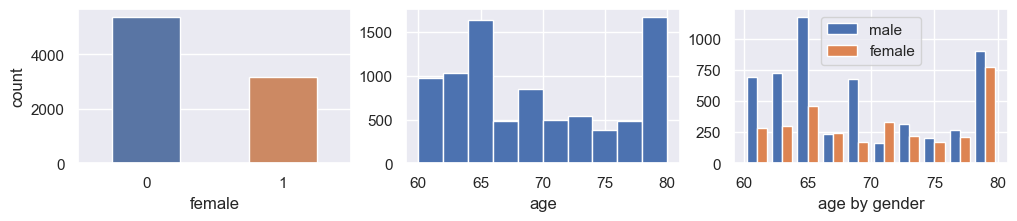

In [9]:
plot_patient_age_gender(adjusted_df)

---

## split train/test datasets

In [10]:
X = scaled_df.drop('low_global_re', axis=1)
y = scaled_df['low_global_re']

In [11]:
# X.head()

In [12]:
# create test and train datasets
X_train, X_test, y_train, y_test = \
    train_test_split(
        X,
        y,
        test_size=0.3, 
        random_state=42, 
        stratify=y
    )

---

In [13]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [14]:
clf = Sequential()
clf.add(Dense(activation = "relu", input_dim = 6, 
                     units = 6, kernel_initializer = "uniform"))
clf.add(Dense(activation = "relu", units = 4, 
                     kernel_initializer = "uniform"))
# clf.add(Dense(activation = "relu", units = 2, 
#                      kernel_initializer = "uniform"))  # adding extra layer doesn't help
clf.add(Dense(activation = "sigmoid", units = 1, 
                     kernel_initializer = "uniform"))
clf.compile(optimizer = 'adam' , loss = 'binary_crossentropy', 
                   metrics = ['accuracy'] )

Metal device set to: Apple M1 Max


2023-03-20 23:20:14.333902: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-20 23:20:14.334297: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
clf.fit(X_train , y_train , batch_size = 8 ,epochs = 10, verbose=False)

2023-03-20 23:20:28.026843: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-20 23:20:28.212214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [16]:
y_proba = clf.predict(X_test)
y_pred = tf.greater(y_proba, 0.5)

81/81 [==============================] - 0s 2ms/step


2023-03-20 23:21:19.317243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [17]:
auc_score = round(roc_auc_score(y_test, y_proba), 5)
report = classification_report(y_test, y_pred, zero_division=0)

In [18]:
print(f'AUC: {auc_score}')
print(report)

AUC: 0.80277
              precision    recall  f1-score   support

         0.0       0.84      0.93      0.88      2002
         1.0       0.59      0.37      0.45       565

    accuracy                           0.80      2567
   macro avg       0.71      0.65      0.67      2567
weighted avg       0.78      0.80      0.79      2567



In [19]:
confusion_matrix(y_test,y_pred)

array([[1857,  145],
       [ 358,  207]])

In [20]:
clf.save('tf_classifier')

INFO:tensorflow:Assets written to: tf_classifier/assets
